In [22]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [3]:
df_final = pd.read_csv('../Data/df_final.csv', index_col="time")
X = df_final.drop(columns=['generation solar','generation wind onshore', 'forecast wind onshore day ahead', 'forecast solar day ahead'])
y_solar = df_final['generation solar']
y_wind = df_final['generation wind onshore']

In [32]:
X_train

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,rain_1h_Valencia,rain_3h_Valencia,snow_3h_Valencia,clouds_all_Valencia,weather_broken clouds_Valencia,weather_few clouds_Valencia,weather_light rain_Valencia,weather_others_Valencia,weather_scattered clouds_Valencia,weather_sky is clear_Valencia
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,-0.782826,-0.485044,-0.142047,-0.267275,-2.872984,0.418005,0.565778,-0.388219,0.987972,-2.141673,...,-0.17512,-0.090347,-0.025871,-0.782380,-0.330345,-0.50780,-0.219299,-0.261562,-0.333312,1.026958
2015-01-01 00:00:00+00:00,-0.747478,-0.487656,0.091974,-0.300770,-2.941264,0.490236,0.431258,-0.535880,0.987972,-2.141673,...,-0.17512,-0.090347,-0.025871,-0.782380,-0.330345,-0.50780,-0.219299,-0.261562,-0.333312,1.026958
2015-01-01 01:00:00+00:00,-0.765152,-0.500719,-0.133404,-0.389073,-2.958334,0.799434,0.315955,-0.711726,0.991465,-2.141673,...,-0.17512,-0.090347,-0.025871,-0.782380,-0.330345,-0.50780,-0.219299,-0.261562,-0.333312,1.026958
2015-01-01 02:00:00+00:00,-0.941889,-0.680982,-0.494408,-0.617444,-2.907124,1.229016,0.239087,-1.074445,0.990300,-2.141673,...,-0.17512,-0.090347,-0.025871,-0.782380,-0.330345,-0.50780,-0.219299,-0.261562,-0.333312,1.026958
2015-01-01 03:00:00+00:00,-1.118625,-0.856019,-0.616737,-0.765123,-2.975404,1.638323,0.251898,-1.110594,0.989136,-2.141673,...,-0.17512,-0.090347,-0.025871,-0.782380,-0.330345,-0.50780,-0.219299,-0.261562,-0.333312,1.026958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31 19:00:00+00:00,-2.037656,-1.344557,1.097865,-0.643833,-0.926993,-0.675592,-0.270167,1.412510,0.972837,-1.712343,...,-0.17512,-0.090347,-0.025871,-0.093257,-0.330345,1.96928,-0.219299,-0.261562,-0.333312,-0.973749
2015-12-31 20:00:00+00:00,-1.754877,-1.344557,0.487549,-0.657028,-1.422026,-0.675592,-0.347036,0.801647,0.971673,-1.467011,...,-0.17512,-0.090347,-0.025871,-0.093257,-0.330345,1.96928,-0.219299,-0.261562,-0.333312,-0.973749
2015-12-31 21:00:00+00:00,-1.595814,-1.344557,-0.156673,-0.831604,-1.626867,-0.584353,-0.465541,-0.216663,0.968180,-1.283013,...,-0.17512,-0.090347,-0.025871,-0.093257,-0.330345,1.96928,-0.219299,-0.261562,-0.333312,-0.973749


In [13]:
def split_by_date(X,train_end_date):
    if not isinstance(train_end_date, pd.Timestamp):
        train_end_date = pd.Timestamp(train_end_date)

    # Convert index of X and y to Timestamp objects if they are strings
    if isinstance(X.index[0], str):
        X.index = pd.to_datetime(X.index)
        
    X_train = X[X.index <= train_end_date]
    X_test = X[X.index > train_end_date]
    
    return X_train, X_test

train_end_date = pd.to_datetime('2015-12-31 23:00:00+00:00')
X_train, X_test = split_by_date(X,train_end_date)
y_solar_train,y_solar_test = split_by_date(y_solar,train_end_date)

# Standardize all columns except target
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)

X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

In [14]:
# Initialize and train the XGBoost classifier
xg_reg = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train_scaled, y_solar_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, ...)

In [18]:
param_grid = {
    'max_depth': [2,5,10],
    'alpha': [2,5,10],
    'learning_rate': [0.1, 0.2,0.5],
    'n_estimators': [20,50,80],
    'colsample_bytree': [0.3, 0.5,0.8]
}

grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_search.fit(X_train_scaled, y_solar_train)

# Print best parameters found by GridSearchCV
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'alpha': 5, 'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 80}


In [24]:
# Re-train the model with the best parameters on the full training set
xgb_optimized = XGBRegressor(**best_params, use_label_encoder=False, objective ='reg:squarederror', random_state=42)
xgb_optimized.fit(X_train_scaled, y_solar_train)

# Make predictions on the test set
y_solar_pred_optimized = xgb_optimized.predict(X_test_scaled)

# Calculate and print the accuracy on the test set
MSE = mean_squared_error(y_solar_test, y_solar_pred_optimized)
print("Test set accuracy with optimized parameters: {:.2f}".format(MSE))

Test set accuracy with optimized parameters: 1725297.96


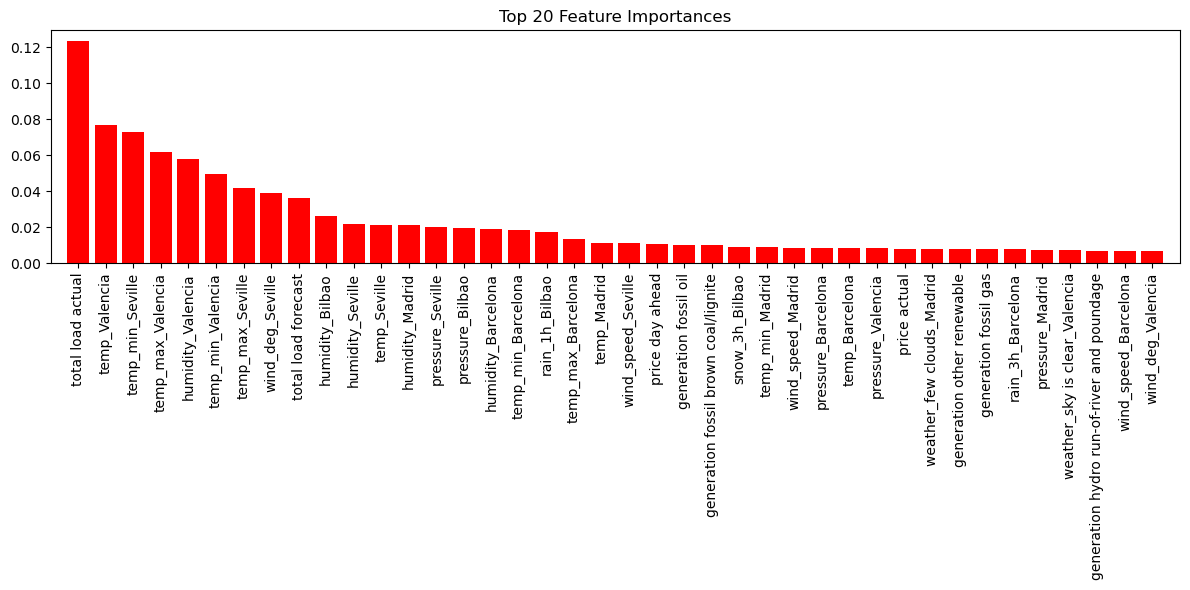

In [28]:
importances = xg_reg.feature_importances_
indices = np.argsort(importances)[::-1][:40]  # Select top 20 most important features
plt.figure(figsize=(12, 6))  # Increase width of the plot
plt.title('Top 20 Feature Importances')
plt.bar(range(len(indices)), importances[indices], color='r', align='center')
plt.xticks(range(len(indices)), X_train.columns[indices], rotation=90)
plt.xlim([-1, len(indices)])
plt.tight_layout()  # Adjust layout for better readability
plt.show()
